[View in Colaboratory](https://colab.research.google.com/github/debu999/keraslearn/blob/master/salt_identification.ipynb)

In [5]:
#Download Dependencies
!pip install imageio
!pip install torch
!pip install kaggle
#!pip install pywidgets

    100% |████████████████████████████████| 3.3MB 940kB/s 
  Running setup.py bdist_wheel for imageio ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio
    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58df4000 @  0x7fd5f43211c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 3.9MB/s 
    100% |████████████████████████████████| 235kB 7.6MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - d

In [0]:
#import dependencies
import os
import numpy as np
import pandas as pd
import platform
from pprint import pprint as pp
import imageio
import matplotlib.pyplot as plt
import torch
from torch.utils import data


In [11]:
pp([platform.architecture(), platform.platform(), platform.processor(), platform.system()])

[('64bit', ''),
 'Linux-4.14.33+-x86_64-with-Ubuntu-17.10-artful',
 'x86_64',
 'Linux']


In [8]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [11]:
#upload the kaggle credentials
from google.colab import files
files.upload()

{}

In [12]:
#is it there?
ls -lrt kaggle*

-rw-r--r-- 1 root root 62 Sep 13 14:58 kaggle.json


In [13]:
#create kaggle folder whoami is root
!rm -rfv ~/.kaggle
!mkdir -pv ~/.kaggle
!cp -v kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: created directory '/root/.kaggle'
'kaggle.json' -> '/root/.kaggle/kaggle.json'


In [14]:
#Download our Dataset
import sys
from kaggle import cli
"""If you have not joined the competition it will send 403 error.
Please join the competition."""

"""--force is to force download the file even if its already downloded."""
sys.argv = 'kaggle competitions download -c tgs-salt-identification-challenge --force'.split()

"""calling kaggle cli to get the files using credentials from ~/.kaggle/kaggle.json"""
cli.main()
# !kaggle competitions download -c tgs-salt-identification-challenge 

100%|██████████| 322k/322k [00:00<00:00, 39.2MB/s]


100%|██████████| 264k/264k [00:00<00:00, 47.1MB/s]


100%|██████████| 922k/922k [00:00<00:00, 92.2MB/s]


  0%|          | 0.00/163M [00:00<?, ?B/s]

100%|██████████| 163M/163M [00:01<00:00, 125MB/s]


 13%|█▎        | 5.00M/37.9M [00:00<00:00, 46.7MB/s]

100%|██████████| 37.9M/37.9M [00:00<00:00, 97.5MB/s]

In [15]:
!ls -lrt /root/.kaggle/
!ls -lrt

total 4
-rw------- 1 root root 62 Sep 13 14:59 kaggle.json
total 207600
drwxr-xr-x 2 root root      4096 Sep 11 17:54 sample_data
-rw-r--r-- 1 root root        62 Sep 13 14:58 kaggle.json
-rw-r--r-- 1 root root    329525 Sep 13 14:59 depths.csv
-rw-r--r-- 1 root root    270012 Sep 13 14:59 sample_submission.csv
-rw-r--r-- 1 root root    943702 Sep 13 14:59 train.csv
-rw-r--r-- 1 root root 171262199 Sep 13 14:59 test.zip
-rw-r--r-- 1 root root  39757560 Sep 13 14:59 train.zip


In [0]:
#Unzip
!unzip -qq train.zip 

In [24]:
os.path.curdir
!ls -lrt

total 207884
drwxr-xr-x 2 root root    143360 Jul 16 19:26 masks
drwxr-xr-x 2 root root    143360 Jul 16 19:26 images
drwxr-xr-x 2 root root      4096 Sep 11 17:54 sample_data
-rw-r--r-- 1 root root        62 Sep 13 14:58 kaggle.json
-rw-r--r-- 1 root root    329525 Sep 13 14:59 depths.csv
-rw-r--r-- 1 root root    270012 Sep 13 14:59 sample_submission.csv
-rw-r--r-- 1 root root    943702 Sep 13 14:59 train.csv
-rw-r--r-- 1 root root 171262199 Sep 13 14:59 test.zip
-rw-r--r-- 1 root root  39757560 Sep 13 14:59 train.zip


In [0]:
#Lets create a class to hold our dataset
import os
import numpy as np

class TGSSaltDataset(data.Dataset):
  def __init__(self, root_path, file_list):
    self.root_path = root_path
    self.file_list = file_list
    
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, index):
    file_id = self.file_list[index]
    #image folder + path
    image_folder = os.path.join(self.root_path, "images")
    image_path = os.path.join(image_folder, ".".join([file_id, "png"]))
    
    #mask folder + path
    mask_folder = os.path.join(self.root_path, "masks")
    mask_path = os.path.join(mask_folder, ".".join([file_id, "png"]))
    
    #read the data
    image = np.array(imageio.imread(image_path), dtype=np.uint8)
    mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
#     print(image_path, mask_path)
    return image, mask
  
  

In [0]:
#initialise by adding the data to the platform
train_mask = pd.read_csv("train.csv")
depth = pd.read_csv("depths.csv")
train_path = os.getcwd()
file_list = list(train_mask.id.values)
dataset = TGSSaltDataset(train_path, file_list)


In [0]:
#Function to visualize the images
def plot2x2array(image, mask):
  #plot matplotlib plots to visualize data
  f, arr = plt.subplots(1, 2)
  arr[0].imshow(image)
  arr[1].imshow(mask)
  arr[0].grid()
  arr[1].grid()
  arr[0].set_title("Image")
  arr[1].set_title("Mask")
  

  
  

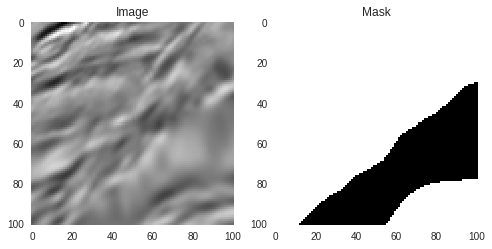

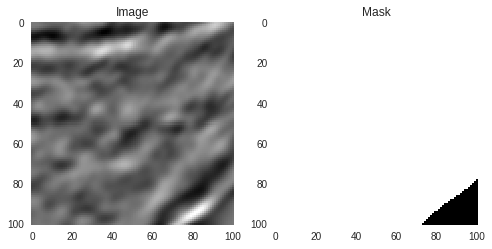

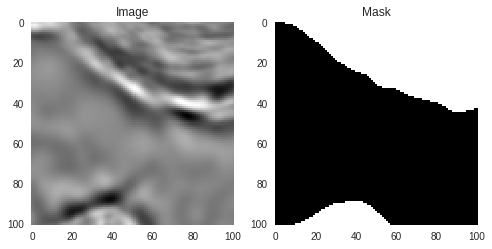

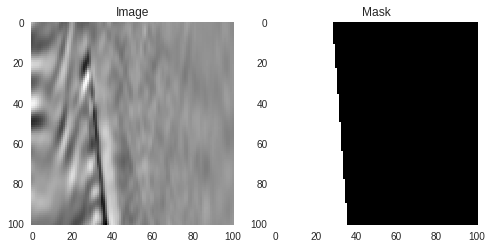

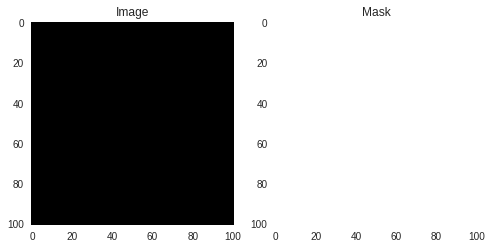

In [29]:
#print the images

for i in range(5):
  image, mask = dataset[np.random.randint(0, len(dataset))]
  plot2x2array(image, mask=mask)

Text(0.5,1,'Depth Distribution')

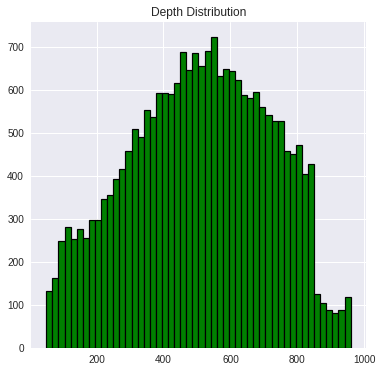

In [30]:
#plot distribution of depths
plt.figure(figsize=(6,6))
plt.hist(depth.z, bins=50, color="green", edgecolor='black', linewidth=1.2)
plt.title("Depth Distribution")

In [31]:
train_mask.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
id          4000 non-null object
rle_mask    2438 non-null object
dtypes: object(2)
memory usage: 62.6+ KB


In [0]:
#Convert run length encoding to correct values
def rleToMask(rlestring, height, width):
  rows, cols = height, width
  try:
    rleNum = [int(numstr) for numstr in rlestring.split(" ")]
    rlePairs = np.array(rleNum).reshape(-1, 2)
    img = np.zeros(rows*cols, dtype= np.uint8)
    for idx, length in rlePairs:
      idx -= 1
      img[idx:idx+length]=255
    
    img = img.reshape(cols, rows).T
    
  except Exception as err:
    img = np.zeros(rows*cols, dtype= np.uint8)
    
  return img


In [33]:
import numpy as np
a=range(15)
print(np.array(a).reshape(5,3).T, np.array(a).reshape(3,5).T)


[[ 0  3  6  9 12]
 [ 1  4  7 10 13]
 [ 2  5  8 11 14]] [[ 0  5 10]
 [ 1  6 11]
 [ 2  7 12]
 [ 3  8 13]
 [ 4  9 14]]


In [0]:
#function for how salty a image is
def saltProportion(imgarr):
  try:
    unique, counts = np.unique(imgarr, return_counts=True)
    return counts[1]/10201.
  except:
    return 0.0
  

In [35]:
train_mask["mask"] = train_mask["rle_mask"].apply(lambda x: rleToMask(x, 101, 101))
train_mask.head()
train_mask["salt_proportion"] = train_mask["mask"].apply(lambda x: saltProportion(x))
train_mask.head()

,id,rle_mask,mask,salt_proportion
0,575d24d81d,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839


In [36]:
r= train_mask.iloc[2,2]
[(a[0], a[1]) for a in enumerate(r) if a[1].any()][15:19]

[(15, array([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255], dtype=uint8)),
 (16, array([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 

In [37]:
#merge it
merged = train_mask.merge(depth, how="left")
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5,1,'Proportion of Salt vs Depth')

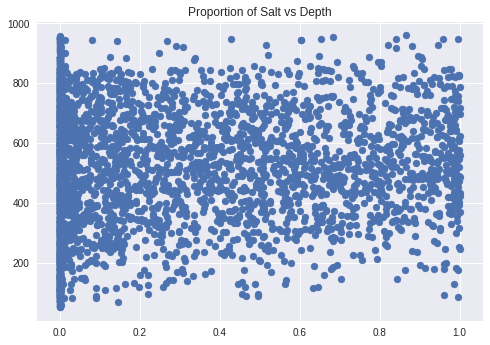

In [38]:
#show proportion of salt vs depth
import matplotlib.pyplot as plt

plt.figure(126)
plt.scatter(merged.salt_proportion, merged.z)
plt.title("Proportion of Salt vs Depth")

In [0]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [0]:
im_width, im_height = 128, 128
border = 5
im_chan = 2 #num of channels first is original second is cumsom(axis=0)
n_features = 1
#no train and test path we will use scikit learn test_train_split


In [0]:
#Build Unet Model
i_img = Input((im_height, im_width, im_chan), name="img")
i_feature = Input((n_features, ), name="feat")

c1 = Conv2D(8, (3,3), activation="relu", padding="same")(i_img)
c1 = Conv2D(8, (3,3), activation="relu", padding="same")(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(16, (3,3), activation="relu", padding="same")(p1)
c2 = Conv2D(16, (3,3), activation="relu", padding="same")(c2)
p2 = MaxPooling2D((2,2))(c2)


c3 = Conv2D(32, (3,3), activation="relu", padding="same")(p2)
c3 = Conv2D(32, (3,3), activation="relu", padding="same")(c3)
p3 = MaxPooling2D((2,2))(c3)


c4 = Conv2D(64, (3,3), activation="relu", padding="same")(p3)
c4 = Conv2D(64, (3,3), activation="relu", padding="same")(c4)
p4 = MaxPooling2D((2,2))(c4)

#Join features in depthest layer
f_repeat = RepeatVector(8*8)(i_feature)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

d5 = Conv2D(128, (3,3), activation="relu", padding="same")(p4_feat)
d5 = Conv2D(128, (3,3), activation="relu", padding="same")(d5)

d4 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(d5)
d4 = concatenate([d4, c4])
e4 = Conv2D(64, (3,3), activation="relu", padding="same")(d4)
e4 = Conv2D(64, (3,3), activation="relu", padding="same")(e4)

d3 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(e4)
d3 = concatenate([d3, c3])
e3 = Conv2D(32, (3,3), activation="relu", padding="same")(d3)
e3 = Conv2D(32, (3,3), activation="relu", padding="same")(e3)

d2 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(e3)
d2 = concatenate([d2, c2])
e2 = Conv2D(16, (3,3), activation="relu", padding="same")(d2)
e2 = Conv2D(16, (3,3), activation="relu", padding="same")(e2)

d1 = Conv2DTranspose(8, (2,2), strides=(2,2), padding="same")(e2)
d1 = concatenate([d1, c1], axis=3)
e1 = Conv2D(8, (3,3), activation="relu", padding="same")(d1)
e1 = Conv2D(8, (3,3), activation="relu", padding="same")(e1)

In [55]:
outputs = Conv2D(1, (1,1), activation="sigmoid")(e1)
model = Model(inputs=[i_img, i_feature], outputs=[outputs])
model.compile(optimizer="adam", loss="binary_crossentropy")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 128, 128, 8)  584         conv2d_41[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_42[0][0]                  
__________________________________________________________________________________________________
conv2d_43 

In [0]:
#Model Train
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from skimage.transform import resize

train_ids = next(os.walk(train_path+"/images"))[2]

In [0]:
train_ids = next(os.walk(os.path.join(train_path, "images")))[2]

In [75]:
# os.walk(os.path.join(train_path, "images"))
# train_ids
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)

X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)

print("Getting and resizing trained images and masks")
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = train_path
  img = load_img(path+"/images/"+id_, grayscale=True)
  x_img = img_to_array(img)
  x_img = resize(x_img, (128, 128, 1), mode="constant", preserve_range=True)
  
  #create cumsum x
  xcentermean = x_img[border:-border, border:-border].mean()
  xcsum = (np.float32(x_img)-xcentermean).cumsum(axis=0)
  xcsum -= xcsum[border:-border, border:-border].mean()
  xcsum /= max(1e-3, xcsum[border:-border, border:-border].std())
  
  #Load Y
  mask = img_to_array(load_img(path+"/masks/"+id_, grayscale=True))
  mask = resize(mask, (128, 128, 1), mode="constant", preserve_range=True)
  
  #Save images
  X[n, ..., 0] = x_img.squeeze()/255
  X[n, ..., 1] = xcsum.squeeze()
  
  y[n] = mask/255
  
  
print("Done!")

Getting and resizing trained images and masks


100%|██████████| 4000/4000 [00:21<00:00, 185.87it/s]

Done!


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [77]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=100, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/100
3400/3400 [==============================] - 20s 6ms/step - loss: 0.5790 - val_loss: 0.5239

Epoch 00001: val_loss improved from inf to 0.52390, saving model to model-tgs-salt-1.h5
Epoch 2/100
3400/3400 [==============================] - 16s 5ms/step - loss: 0.4591 - val_loss: 0.3764

Epoch 00002: val_loss improved from 0.52390 to 0.37643, saving model to model-tgs-salt-1.h5
Epoch 3/100
3400/3400 [==============================] - 16s 5ms/step - loss: 0.3797 - val_loss: 0.3215

Epoch 00003: val_loss improved from 0.37643 to 0.32154, saving model to model-tgs-salt-1.h5
Epoch 4/100
3400/3400 [==============================] - 16s 5ms/step - loss: 0.3146 - val_loss: 0.3124

Epoch 00004: val_loss improved from 0.32154 to 0.31238, saving model to model-tgs-salt-1.h5
Epoch 5/100
3400/3400 [==============================] - 16s 5ms/step - loss: 0.2695 - val_loss: 0.2579

Epoch 00005: val_loss improved from 0.31238 to 0.25791, saving m